In [1]:
# imports

import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pycmap
import seaborn as sns
from tlviz.factor_tools import factor_match_score
import xarray as xr
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

grays = ['#0F0A0A', '#52525E', '#747688', '#959AB1', '#959AB1', '#CECFD5', '#E0E0E0']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

# div_hexes = ['#7222D3', neutral_color, '#FF780A']
# div_cmap = get_continuous_cmap(div_hexes)


In [3]:
# helper functions

def unique_bins(array, n_bins, bounds=None, reverse=False):
    '''This is a function that maps an array of continuous values with potential duplicates to 
    a set of bins in such a way that each of the original continuous values is mapped to a unique bin, and the
    distribution of binned values approximates the distribution of continuous values as closely as possible.
    
    My quick and dirty approach to this problem sorts the input array into the appropriate number of bins. Then,
    starting in the middle and alternating outward left and right, the algorithm checks to see if each bin has 
    more than one resident. If so, it will again alternate outward left and right from that position and allocate
    the extra residents to the nearest free bins.
    
    Parameters
    ----------
    array : np.array
        Sorted array of values to be placed into bins.
    n_bins : int
        Number of bins to use.
    bounds : (float, float)
        Upper and lower bounds to use for bin-mapping.
    reverse : bool
        Optional flag to reverse the index ordering of the output.
    
        
    Returns
    -------
    index : np.array
        Indices indicating mapping of input values to bins, where index[i] indicates the index of the bin 
        mapping of input value array[i] (assuming input array is sorted).
    '''
    # check number of bins
    if not n_bins >= len(array):
        raise ValueError('The number of bins must be >= len(array).')
    # add bounds if supplied
    if bounds is not None:
        array = np.concatenate((array, bounds))
    # make histogram
    counts, _ = np.histogram(array, bins=n_bins)
    # remove bounds if added
    if bounds is not None:
        counts[0] -= 1
        counts[-1] -= 1
    # start from the middle
    i = int(n_bins/2)
    for j in range(n_bins):
        # alternate left and right
        if j % 2:
            i -= j
        else:
            i += j
        # resolve collisions
        if counts[i] > 1:
            # set new counter for exploring nearby positions
            k = i
            for l in range(2*n_bins):
                # alternate left and right
                if l % 2:
                    k -= l
                else:
                    k += l
                # check if we're still in range
                if 0 <= k < n_bins:
                    # check for an empty spot
                    if counts[k] == 0:
                        counts[k] = 1
                        counts[i] -= 1
                        # check if all collisions have been resolved yet
                        if counts[i] == 1:
                            break
    # select indices of non-zero values
    index = np.where(counts == 1)[0]
    # reverse if requested
    if reverse:
        index = (n_bins - 1) - index
    return index


# import data
### cluster data

In [43]:
# read in aligned model datasets

datapath = Path('../../data/5-models/')

pro_ds = xr.open_dataset(datapath / 'pro-aligned-models.nc')
syn_ds = xr.open_dataset(datapath / 'syn-aligned-models.nc')

fe_clusters = {'pro': 7, 'syn': 5}
n_clusters = {'pro': 13, 'syn': 13}

pro_ds


<xarray.Dataset>
Dimensions:          (Bootstrap: 100, Replicate: 3, Component: 15,
                      Ortholog: 5023, Clade: 3, SampleName: 74)
Coordinates:
  * Bootstrap        (Bootstrap) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * Replicate        (Replicate) object 'A' 'B' 'C'
  * Component        (Component) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * Ortholog         (Ortholog) int64 60000001 60000002 ... 60040287 60040292
  * Clade            (Clade) object 'HLI' 'HLII' 'LLI'
  * SampleName       (SampleName) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.NS...
Data variables:
    ComponentWeight  (Bootstrap, Replicate, Component) float64 ...
    GeneWeight       (Bootstrap, Replicate, Component, Ortholog) float64 ...
    TaxonWeight      (Bootstrap, Replicate, Component, Clade) float64 ...
    SampleWeight     (Bootstrap, Replicate, Component, SampleName) float64 ...
    Sample           (Bootstrap, Replicate, SampleName) object ...
    Annotation       (Ortholog) object ...
Attributes:
    Rank:               15
    Lambda:             17.0
    AlignRefBootstrap:  93
    AlignRefReplicate:  B

In [5]:
# read in metadata

sample_df = pd.read_csv('../../data/metadata/sample_metadata_merged.csv')

sample_df


,SampleName,Cruise,Year,Datetime,Latitude,Longitude,Depth,Dataset,SampleGroup,TimeFraction,TimeClass,Experiment,Condition,Treatment,Timepoint
0,G2.DCM.NS.S11C2.50m,Gradients 2,2017,6/6/17 6:56,36.999833,-158.000,50,Gradients 2 DCM,depth profiles,0.29,6am,NaN,NaN,NaN,NaN
1,G2.DCM.NS.S15C2.56m,Gradients 2,2017,6/9/17 5:30,34.000167,-158.000,56,Gradients 2 DCM,depth profiles,0.23,6am,NaN,NaN,NaN,NaN
2,G2.DCM.NS.S17C3.87m,Gradients 2,2017,6/10/17 9:34,32.000167,-158.000,87,Gradients 2 DCM,depth profiles,0.40,10am,NaN,NaN,NaN,NaN
3,G2.DCM.NS.S18C2.95m,Gradients 2,2017,6/11/17 5:50,29.582000,-158.002,95,Gradients 2 DCM,depth profiles,0.24,6am,NaN,NaN,NaN,NaN
4,G3.DEPTH.NS.S4C6.75m,Gradients 3,2019,4/16/19 8:00,41.670000,-158.050,75,Gradients 3 depth profile,depth profiles,0.33,10am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,G3.DEPTH.NS.S6C7.15m,Gradients 3,2019,4/22/19 6:44,32.920000,-158.000,15,Gradients 3 depth profile,surface transect,0.28,6am,NaN,NaN,NaN,NaN
83,G3.UW.NS.UW40_1.7m,Gradients 3,2019,4/24/19 5:57,40.880000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
84,G3.DEPTH.NS.S8C2.15m,Gradients 3,2019,4/24/19 14:47,42.330000,-158.000,15,Gradients 3 depth profile,surface transect,0.62,2pm,NaN,NaN,NaN,NaN
85,G3.UW.NS.UW40_2.7m,Gradients 3,2019,4/25/19 6:01,40.090000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


In [8]:
# pull out clusters hypothesized to relate to iron limitation

pro_fe_df = pro_ds.sel(Component=fe_clusters['pro']).SampleWeight.to_series().reset_index()
pro_fe_df['Genus'] = 'Prochlorococcus'
syn_fe_df = syn_ds.sel(Component=fe_clusters['syn']).SampleWeight.to_series().reset_index()
syn_fe_df['Genus'] = 'Synechococcus'

fe_cluster_df = pd.concat([pro_fe_df, syn_fe_df]).reset_index(drop=True)
fe_cluster_df = pd.merge(fe_cluster_df, sample_df, on='SampleName', how='left')

fe_cluster_df


,Bootstrap,Replicate,SampleName,SampleWeight,Genus,Cruise,Year,Datetime,Latitude,Longitude,Depth,Dataset,SampleGroup,TimeFraction,TimeClass,Experiment,Condition,Treatment,Timepoint
0,0,A,G1.SURF.NS.S02C1.15m,0.000000,Prochlorococcus,Gradients 1,2016,4/20/16 5:51,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
1,0,A,G1.SURF.NS.S04C1.15m,0.029022,Prochlorococcus,Gradients 1,2016,4/22/16 5:40,28.143167,-158.000667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
2,0,A,G1.SURF.NS.S06C1.15m,NaN,Prochlorococcus,Gradients 1,2016,4/24/16 5:37,32.583500,-158.001667,15,Gradients 1 surface,surface transect,0.23,6am,NaN,NaN,NaN,NaN
3,0,A,G1.SURF.NS.S08C1.15m,0.012420,Prochlorococcus,Gradients 1,2016,4/26/16 5:43,37.301167,-158.001667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
4,0,A,G1.SURF.NS.S09C1.15m,0.060454,Prochlorococcus,Gradients 1,2016,4/27/16 5:41,36.570000,-158.003167,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48295,99,C,G3.UW.NS.UW35_2.7m,0.119080,Synechococcus,Gradients 3,2019,4/26/19 5:55,35.830000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
48296,99,C,G3.UW.NS.UW37_1.7m,0.091827,Synechococcus,Gradients 3,2019,4/20/19 6:12,37.000000,-158.000000,7,Gradients 3 underway,surface transect,0.26,6am,NaN,NaN,NaN,NaN
48297,99,C,G3.UW.NS.UW38_1.7m,0.032532,Synechococcus,Gradients 3,2019,4/15/19 5:37,38.970000,-158.000000,7,Gradients 3 underway,surface transect,0.23,6am,NaN,NaN,NaN,NaN
48298,99,C,G3.UW.NS.UW40_1.7m,0.043032,Synechococcus,Gradients 3,2019,4/24/19 5:57,40.880000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


In [9]:
# pull out clusters hypothesized to relate to nitrogen limitation

pro_n_df = pro_ds.sel(Component=n_clusters['pro']).SampleWeight.to_series().reset_index()
pro_n_df['Genus'] = 'Prochlorococcus'
syn_n_df = syn_ds.sel(Component=n_clusters['syn']).SampleWeight.to_series().reset_index()
syn_n_df['Genus'] = 'Synechococcus'

n_cluster_df = pd.concat([pro_n_df, syn_n_df]).reset_index(drop=True)
n_cluster_df = pd.merge(n_cluster_df, sample_df, on='SampleName', how='left')

n_cluster_df

,Bootstrap,Replicate,SampleName,SampleWeight,Genus,Cruise,Year,Datetime,Latitude,Longitude,Depth,Dataset,SampleGroup,TimeFraction,TimeClass,Experiment,Condition,Treatment,Timepoint
0,0,A,G1.SURF.NS.S02C1.15m,0.025433,Prochlorococcus,Gradients 1,2016,4/20/16 5:51,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
1,0,A,G1.SURF.NS.S04C1.15m,0.137386,Prochlorococcus,Gradients 1,2016,4/22/16 5:40,28.143167,-158.000667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
2,0,A,G1.SURF.NS.S06C1.15m,NaN,Prochlorococcus,Gradients 1,2016,4/24/16 5:37,32.583500,-158.001667,15,Gradients 1 surface,surface transect,0.23,6am,NaN,NaN,NaN,NaN
3,0,A,G1.SURF.NS.S08C1.15m,0.168421,Prochlorococcus,Gradients 1,2016,4/26/16 5:43,37.301167,-158.001667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
4,0,A,G1.SURF.NS.S09C1.15m,0.161893,Prochlorococcus,Gradients 1,2016,4/27/16 5:41,36.570000,-158.003167,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48295,99,C,G3.UW.NS.UW35_2.7m,0.064537,Synechococcus,Gradients 3,2019,4/26/19 5:55,35.830000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
48296,99,C,G3.UW.NS.UW37_1.7m,0.152656,Synechococcus,Gradients 3,2019,4/20/19 6:12,37.000000,-158.000000,7,Gradients 3 underway,surface transect,0.26,6am,NaN,NaN,NaN,NaN
48297,99,C,G3.UW.NS.UW38_1.7m,0.000000,Synechococcus,Gradients 3,2019,4/15/19 5:37,38.970000,-158.000000,7,Gradients 3 underway,surface transect,0.23,6am,NaN,NaN,NaN,NaN
48298,99,C,G3.UW.NS.UW40_1.7m,0.000000,Synechococcus,Gradients 3,2019,4/24/19 5:57,40.880000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


# import data
### environmental data

In [10]:
# define salinity and chlorophyll fronts

# source: Juranek et al., 2020 https://doi.org/10.1029/2020GB006702
sal_fronts = {2016: 32.15, 2017: 32.5, 2019: 32.34}
chl_fronts = {2016: 33, 2017: 36.2, 2019: 35}


In [11]:
# import data from cmap

api = pycmap.API(token='55bd80f9-8d5d-4c8f-8917-f5b0e924ed45')
api.search_catalog('iron John gradients')


,Variable,Table_Name,Long_Name,Unit,Make,Sensor,Process_Level,Study_Domain,Temporal_Resolution,Spatial_Resolution,...,Data_Source,Distributor,Dataset_Description,Acknowledgement,Dataset_ID,ID,Visualize,Keywords,Unstructured_Dataset_Metadata,Unstructured_Variable_Metadata
0,Fe_dissolved,tblKM1906_Gradients3_Diss_Trace_Metal_Profile,Dissolved Iron Concentrations,nmol/L,Observation,ICP-MS,Reprocessed,Chemistry,Irregular,Irregular,...,"John Lab, University of Southern California","John Lab, University of Southern California",Samples were collected in the North Pacific on...,Sample collection and analysis was supported b...,522,10691,1,"biogeochemistry, chemistry, cruise, Dissolved ...",NaN,NaN
1,Fe_dissolved,tblKOK1606_Gradients1_Diss_Trace_Metal_Profile,Dissolved Iron Concentrations,nmol/L,Observation,ICP-MS,Reprocessed,Chemistry,Irregular,Irregular,...,"John Lab, University of Southern California","John Lab, University of Southern California",Samples were collected in the North Pacific on...,Sample collection and analysis was supported b...,548,11060,1,"biogeochemistry, chemistry, cruise, Dissolved ...",NaN,NaN
2,Fe,tblMGL1704_Gradients2_Trace_Metals,Dissolved Iron Concentrations,nM,Observation,Towfish,Reprocessed,Chemistry+Biogeochemistry,Irregular,Irregular,...,John Lab USC,John Lab - USC,Samples were collected in the North Pacific on...,John Lab - USC,575,11510,1,"biogeochemistry, chemistry, cruise, dissolved ...",NaN,NaN
3,Fe_dissolved,tblMGL1704_Gradients2_Diss_Trace_Metal_Profile,Dissolved Iron Concentrations,nmol/L,Observation,ICP-MS,Reprocessed,Chemistry,Irregular,Irregular,...,"John Lab, University of Southern California","John Lab, University of Southern California",Samples were collected in the North Pacific on...,Sample collection and analysis was supported b...,547,11054,1,"biogeochemistry, chemistry, cruise, Dissolved ...",NaN,NaN
4,Fe_dissolved,tblMGL1704_Gradients2_Diss_Trace_Metal_Surface,Dissolved Iron Concentrations,nmol/L,Observation,ICP-MS,Reprocessed,Chemistry,Irregular,Irregular,...,"John Lab, University of Southern California","John Lab, University of Southern California",Samples were collected in the North Pacific on...,Sample collection and analysis was supported b...,546,11048,1,"biogeochemistry, chemistry, cruise, Dissolved ...",NaN,NaN


In [12]:
# import all iron data from G1, G2, G3

fe_df = pd.concat([
    api.get_dataset('tblKOK1606_Gradients1_Diss_Trace_Metal_Profile'), 
    api.get_dataset('tblMGL1704_Gradients2_Diss_Trace_Metal_Profile'), 
    api.get_dataset('tblMGL1704_Gradients2_Diss_Trace_Metal_Surface'), 
    api.get_dataset('tblKM1906_Gradients3_Diss_Trace_Metal_Profile')
]).reset_index(drop=True)
fe_df['year'] = pd.to_datetime(fe_df['time']).dt.year

fe_df

,time,lat,lon,depth,Cd_dissolved,Pb_dissolved,Fe_dissolved,Ni_dissolved,Cu_dissolved,Zn_dissolved,Mn_dissolved,Co_dissolved,year
0,2016-04-20T08:00:00,23.500000,-158.00000,15.0,0.000000,42.387016,0.133943,2.112766,0.520765,0.406267,0.978415,2.886313,2016
1,2016-04-20T08:00:00,23.500000,-158.00000,45.0,0.000000,40.404233,0.112573,2.144578,0.487953,0.041618,0.956071,1.607434,2016
2,2016-04-20T08:00:00,23.500000,-158.00000,130.0,2.619439,38.345184,0.148592,2.123560,0.530634,0.376382,0.616861,5.833796,2016
3,2016-04-20T08:00:00,23.500000,-158.00000,150.0,9.897086,40.218990,0.397744,2.192099,0.562793,0.346099,0.508902,5.351234,2016
4,2016-04-20T08:00:00,23.500000,-158.00000,200.0,56.298971,70.479227,0.402671,2.449607,0.689346,0.183127,0.334094,11.862347,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,2019-04-24T00:00:00,42.333888,-158.00595,75.0,0.156920,0.051880,0.423880,3.489863,1.107804,0.624393,0.859485,0.016049,2019
357,2019-04-24T00:00:00,42.333888,-158.00595,100.0,0.208297,0.069508,1.140576,3.679030,1.401452,2.271989,0.795996,0.021737,2019
358,2019-04-24T00:00:00,42.333888,-158.00595,200.0,0.436411,0.078711,1.454341,4.160885,1.469514,3.321238,0.484288,0.027267,2019
359,2019-04-24T00:00:00,42.333888,-158.00595,300.0,0.581454,0.082272,1.584558,4.917585,1.768565,4.342330,0.446200,0.029886,2019


In [14]:
# import nitrogen data from G1, G2, G3

# dissolved nitrate+nitrite (Karl lab)
n_df =  pd.concat([
    api.get_dataset('tblKOK1606_Gradients1_Nutrients'), 
    api.get_dataset('tblMGL1704_Gradients2_Nutrients'), 
    api.get_dataset('tblKM1906_Gradients3_Organic_Inorganic_Nutrients').rename(columns={'NO3_plus_NO2': 'NO3_NO2'})
]).reset_index(drop=True)
n_df['year'] = pd.to_datetime(n_df['time']).dt.year

# drop any rows that don't have nitrate+nitrite values
n_df = n_df[n_df['NO3_NO2'].notna()]

n_df


,time,lat,lon,depth,Station,Cast,RosPos,SiO4,NO3_NO2,PO4,TOC,NH4,TN,TON,TP,T_OP,NO2,year
10,2016-04-21T19:48:18,23.596333,-157.955333,198.547506,2 ...,3.0,1.0,4.841292,5.022449,0.406518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
11,2016-04-21T19:52:03,23.596333,-157.955333,149.214103,2 ...,3.0,3.0,2.714948,2.159658,0.215674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
12,2016-04-21T19:52:21,23.596333,-157.955333,149.382903,2 ...,3.0,4.0,2.681088,2.214343,0.210792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
13,2016-04-21T19:55:05,23.596333,-157.955333,110.098362,2 ...,3.0,5.0,1.818020,0.578094,0.106029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
14,2016-04-21T19:58:09,23.596333,-157.955333,75.107340,2 ...,3.0,8.0,1.269541,0.000000,0.042003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,2019-04-27T06:04:59,33.230865,-157.998872,7.000000,Underway56,NaN,NaN,NaN,0.009382,0.044702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
428,2019-04-27T08:50:11,32.721290,-157.999772,7.000000,Underway57,NaN,NaN,NaN,0.006008,0.040763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
429,2019-04-27T11:55:46,32.161412,-157.999878,7.000000,Underway58,NaN,NaN,NaN,0.012590,0.025703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
430,2019-04-27T15:22:00,31.537025,-157.993222,7.000000,Underway59,NaN,NaN,3.072060,0.013660,0.061354,59.815844,0.016635,4.149282,4.135623,0.212595,0.151241,0.004416,2019


In [15]:
# merge Fe data on dissolved N data

# only select surface and depth samples for joining
source_df = n_df[n_df.depth.le(15)].reset_index(drop=True)
source_cols = source_df.columns.to_list()
tolerances = [2, 0.25, 0.25, 15] # time, lat, lon, depth

# define target datasets
targets = {
    # dissolved Fe
    'tblKOK1606_Gradients1_Diss_Trace_Metal_Profile': {
        'variables': ['Fe_dissolved'], 
        'tolerances': tolerances
    },
    'tblMGL1704_Gradients2_Diss_Trace_Metal_Profile': {
        'variables': ['Fe_dissolved'], 
        'tolerances': tolerances
    },
    'tblMGL1704_Gradients2_Diss_Trace_Metal_Surface': {
        'variables': ['Fe_dissolved'], 
        'tolerances': tolerances
    },
    'tblKM1906_Gradients3_Diss_Trace_Metal_Profile': {
        'variables': ['Fe_dissolved'], 
        'tolerances': tolerances
    }
}

# join target data on the source dataframe
merged_df = pycmap.Sample(
    source=source_df, 
    targets=targets, 
    replaceWithMonthlyClimatolog=False
)

# merge all of the iron data into one column
fe_start = 'CMAP_Fe_dissolved_tblKOK1606_Gradients1_Diss_Trace_Metal_Profile'
fe_end = 'CMAP_Fe_dissolved_tblKM1906_Gradients3_Diss_Trace_Metal_Profile'
merged_df['Fe_dissolved'] = merged_df.loc[:, fe_start:fe_end].max(axis=1)

# trim the dataframe
merged_df = merged_df[source_cols + ['Fe_dissolved']]

# calculate ratio
merged_df['N:Fe'] = merged_df['NO3_NO2'] / merged_df['Fe_dissolved']

merged_df


Gathering metadata .... 
Sampling starts
Sampling finished                                                                                                    

,time,lat,lon,depth,Station,Cast,RosPos,SiO4,NO3_NO2,PO4,TOC,NH4,TN,TON,TP,T_OP,NO2,year,Fe_dissolved,N:Fe
0,2016-04-21T20:09:35,23.596333,-157.955333,5.544578,2 ...,3.0,23.0,1.257459,0.001400,0.051425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,0.133943,0.010451
1,2016-04-23T23:19:38,28.141000,-158.001167,4.897102,4 ...,4.0,24.0,2.130968,0.001132,0.044776,66.000000,NaN,NaN,NaN,NaN,NaN,NaN,2016,0.309918,0.003654
2,2016-04-25T09:42:08,34.052333,-158.002833,14.475400,7 ...,1.0,13.0,5.418142,2.322685,0.218875,NaN,0.207857,NaN,NaN,NaN,NaN,NaN,2016,0.070247,33.064355
3,2016-04-25T22:59:35,32.676000,-157.994667,4.498135,6 ...,4.0,24.0,3.431834,0.002883,0.067545,62.800000,NaN,NaN,NaN,NaN,NaN,NaN,2016,0.416400,0.006924
4,2016-04-26T09:51:38,37.301167,-158.001667,14.778970,8 ...,1.0,20.0,9.156541,5.874717,0.484636,NaN,0.186932,NaN,NaN,NaN,NaN,NaN,2016,0.135138,43.471890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,2019-04-27T06:04:59,33.230865,-157.998872,7.000000,Underway56,NaN,NaN,NaN,0.009382,0.044702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,NaN,NaN
95,2019-04-27T08:50:11,32.721290,-157.999772,7.000000,Underway57,NaN,NaN,NaN,0.006008,0.040763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,NaN,NaN
96,2019-04-27T11:55:46,32.161412,-157.999878,7.000000,Underway58,NaN,NaN,NaN,0.012590,0.025703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,NaN,NaN
97,2019-04-27T15:22:00,31.537025,-157.993222,7.000000,Underway59,NaN,NaN,3.072060,0.013660,0.061354,59.815844,0.016635,4.149282,4.135623,0.212595,0.151241,0.004416,2019,NaN,NaN


# generate plots
### panel a: ecotype weights

In [44]:
# pull out ecotype weights

with pd.option_context('mode.chained_assignment', None):
    pro_fe_eco_df = pro_ds.sel(Component=fe_clusters['pro']).TaxonWeight.to_series().reset_index()
    pro_fe_eco_df['Genus'] = 'Prochlorococcus'
    pro_fe_eco_df['Cluster'] = f"pro{fe_clusters['pro']}"
    pro_fe_eco_df['ClusterGroup'] = 'Fe'
    pro_n_eco_df = pro_ds.sel(Component=n_clusters['pro']).TaxonWeight.to_series().reset_index()
    pro_n_eco_df['Genus'] = 'Prochlorococcus'
    pro_n_eco_df['Cluster'] = f"pro{n_clusters['pro']}"
    pro_n_eco_df['ClusterGroup'] = 'N'
    syn_fe_eco_df = syn_ds.sel(Component=fe_clusters['syn']).TaxonWeight.to_series().reset_index()
    syn_fe_eco_df['Genus'] = 'Synechococcus'
    syn_fe_eco_df['Cluster'] = f"syn{fe_clusters['syn']}"
    syn_fe_eco_df['ClusterGroup'] = 'Fe'
    syn_n_eco_df = syn_ds.sel(Component=n_clusters['syn']).TaxonWeight.to_series().reset_index()
    syn_n_eco_df['Genus'] = 'Synechococcus'
    syn_n_eco_df['Cluster'] = f"syn{n_clusters['syn']}"
    syn_n_eco_df['ClusterGroup'] = 'N'
ecotype_df = pd.concat([pro_fe_eco_df, pro_n_eco_df, syn_fe_eco_df, syn_n_eco_df])

# swap out clade labels with display labels
clade_order = ['HLI', 'HLII', 'LLI', '5.1B-I', '5.1B-CRD1', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1A-CRD2', '5.1A-UC-A-EnvC']
clade_labels = ['HLI', 'HLII', 'LLI', 'I', 'CRD1', 'II', 'III', 'IV', 'CRD2', 'UC-A']
ecotype_df['Clade'] = ecotype_df['Clade'].map(dict(zip(clade_order, clade_labels)))

ecotype_df


,Bootstrap,Replicate,Clade,TaxonWeight,Genus,Cluster,ClusterGroup
0,0,A,HLI,0.965917,Prochlorococcus,pro7,Fe
1,0,A,HLII,0.231071,Prochlorococcus,pro7,Fe
2,0,A,LLI,0.116666,Prochlorococcus,pro7,Fe
3,0,B,HLI,0.964295,Prochlorococcus,pro7,Fe
4,0,B,HLII,0.251808,Prochlorococcus,pro7,Fe
...,...,...,...,...,...,...,...
2095,99,C,III,0.110246,Synechococcus,syn13,N
2096,99,C,IV,0.537445,Synechococcus,syn13,N
2097,99,C,UC-A,0.003485,Synechococcus,syn13,N
2098,99,C,CRD1,0.589170,Synechococcus,syn13,N


In [48]:
# pull out gene weights

geneweight_df = pd.DataFrame()
# pull gene weights of all clusters
with pd.option_context('mode.chained_assignment', None):
    for genus in ['pro', 'syn']:
        ds = {'pro': pro_ds, 'syn': syn_ds}[genus]
        for clustergroup in ['Fe', 'N']:
            cluster = {'Fe': fe_clusters, 'N': n_clusters}[clustergroup][genus]
            cluster_geneweight_df = ds.sel(Component=cluster).GeneWeight.to_series().reset_index()
            medians = cluster_geneweight_df.groupby('Ortholog').GeneWeight.median()
            cluster_geneweight_df = cluster_geneweight_df[
                cluster_geneweight_df.Ortholog.isin(medians[~medians.eq(0.)].index)].reset_index(drop=True)
            cluster_geneweight_df['Genus'] = {'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[genus]
            cluster_geneweight_df['Cluster'] = f"{genus}{cluster}"
            cluster_geneweight_df['ClusterGroup'] = clustergroup
            cluster_geneweight_df['Annotation'] = cluster_geneweight_df['Ortholog'].map(ds['Annotation'].to_series())
            if len(geneweight_df) == 0:
                geneweight_df = cluster_geneweight_df
            else:
                geneweight_df = pd.concat([geneweight_df, cluster_geneweight_df])

median_gene_df = geneweight_df.groupby(['Cluster', 'Genus', 'ClusterGroup', 'Ortholog', 'Annotation']).GeneWeight.median().reset_index()
median_gene_df[median_gene_df.Cluster == 'pro7'].sort_values('GeneWeight', ascending=False)


,Cluster,Genus,ClusterGroup,Ortholog,Annotation,GeneWeight
8,pro7,Prochlorococcus,Fe,60001290,fructose-bisphosphate aldolase,0.757375
7,pro7,Prochlorococcus,Fe,60001112,flavodoxin I,0.588871
6,pro7,Prochlorococcus,Fe,60000706,iron(III) transport system substrate-binding p...,0.223491
5,pro7,Prochlorococcus,Fe,60000134,RNA polymerase nonessential primary-like sigma...,0.085240
4,pro7,Prochlorococcus,Fe,60000023,chlorophyll a/b binding light-harvesting prote...,0.070026
9,pro7,Prochlorococcus,Fe,60001361,ribulose-5-phosphate 3-epimerase,0.005717


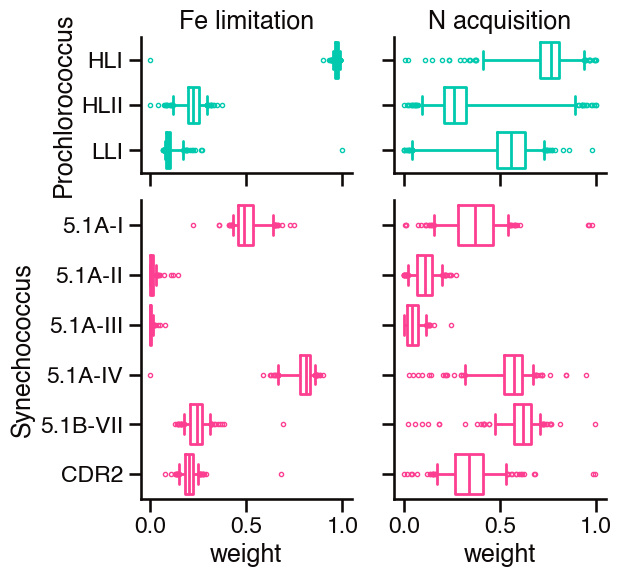

In [14]:
# make ecotype weight figure

# set up figure
sample_weight_range = (-0.05, 1.05) # range of weights to show on sample plots
fig = plt.figure(figsize=(6, 6))
rows = 3
cols = 2
grid = plt.GridSpec(rows, cols, wspace=.2, hspace=.2)

for i, genus in enumerate(['Prochlorococcus', 'Synechococcus']):
    for j, clustergroup in enumerate(['Fe limitation', 'N acquisition']):
        if not i:
            axis = plt.subplot(grid[i, j])
        else:
            axis = plt.subplot(grid[1:3, j])
        plot_df = ecotype_df[(ecotype_df['genus'] == genus) & (ecotype_df['clustergroup'] == clustergroup)]
        sns.boxplot(
            data=plot_df, x='taxonweights', y='clade', hue='genus', 
            hue_order=['Prochlorococcus', 'Synechococcus'], palette=[sns.color_palette()[i] for i in [2, 3]], 
            orient='y', fill=False, whis=(5, 95), fliersize=3, legend=False, ax=axis
        )
        # labels and such
        if i == 0:
            axis.set(title=clustergroup)
        if i == 1:
            xlabel = 'weight'
        else:
            xlabel = None
        if j == 0:
            ylabel = genus
        else:
            ylabel = None
        axis.set(xlim=sample_weight_range, xlabel=xlabel, ylabel=ylabel)
        axis.tick_params(left=True, labelleft=(j==0), bottom=True, labelbottom=(i==1))

# save figure
fig.savefig('fe-n-clusters-taxonweights.png', bbox_inches='tight')


# generate plots
### panel c: surface sample weights

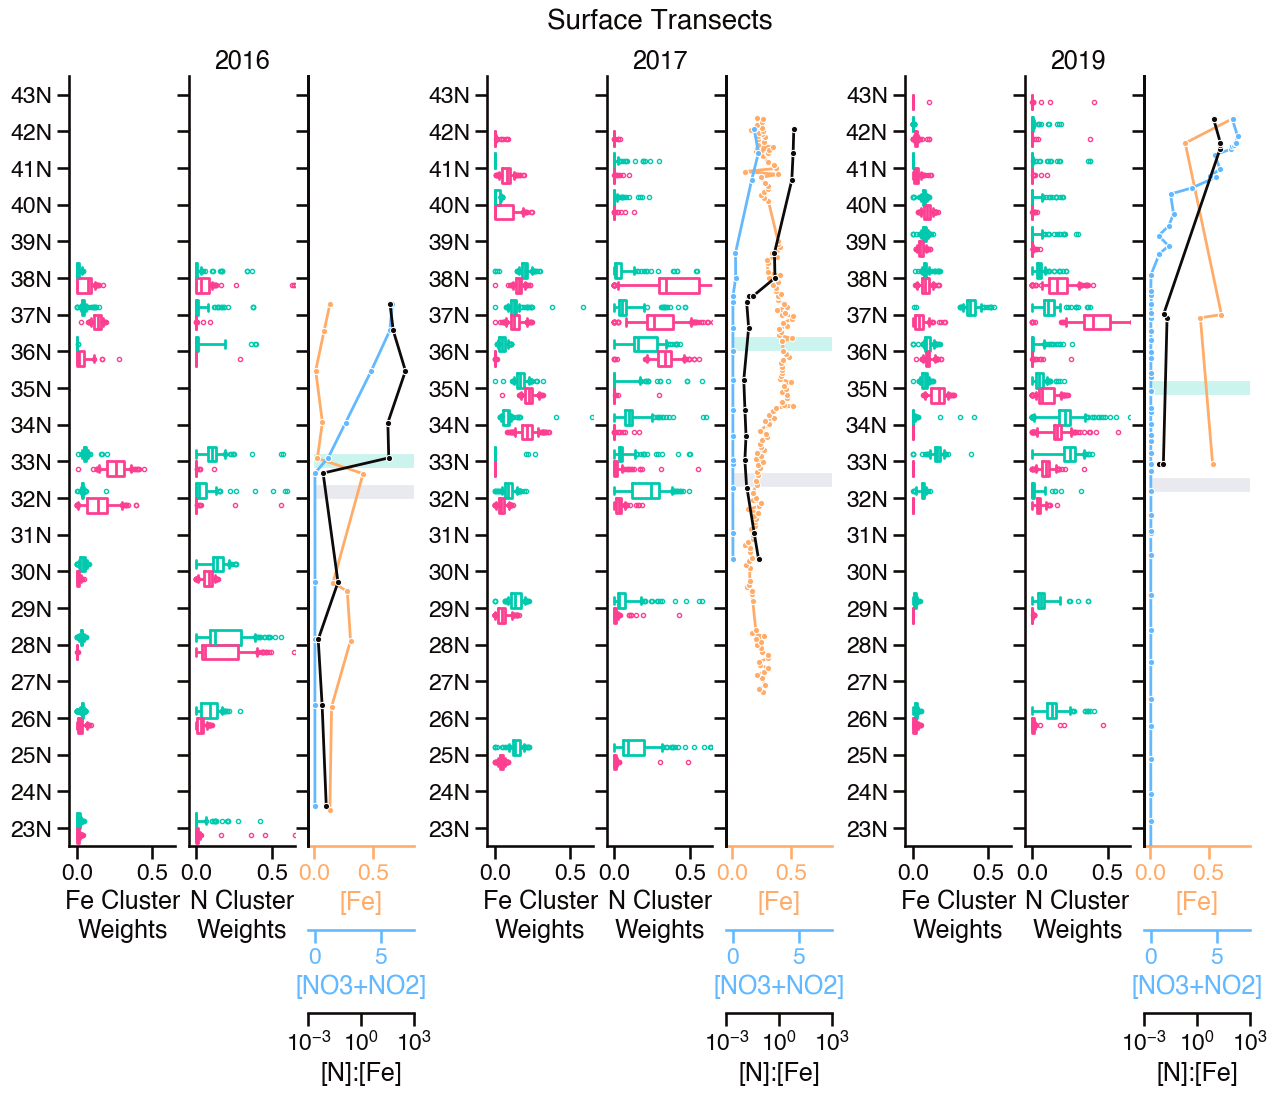

In [66]:
# plot surface transect data, binned sample location, environmental data added

# set up figure
sample_weight_range = (-0.05, 0.65) # range of weights to show on sample plots
fig = plt.figure(figsize=(16, 10))
rows = 1
cols = 21
grid = plt.GridSpec(rows, cols, wspace=.3)
n_bins = 21
bounds = (23, 43)
depth_limit = 15 # meters

# plot cluster weight data
for i, year in enumerate([2016, 2017, 2019]):
    # Fe limitation cluster
    axis = plt.subplot(grid[0, 7*i:7*i+2])
    # get data together
    plot_df = fe_cluster_df[fe_cluster_df['SampleGroup'] == 'surface transect']
    plot_df = plot_df[plot_df['Year'] == year]
    latitudes = plot_df[
        ['SampleName', 'Latitude']].drop_duplicates().set_index('SampleName').sort_values('Latitude')['Latitude']
    lat_bins = unique_bins(latitudes, n_bins, bounds=bounds, reverse=True)
    plot_df['lat_idx'] = plot_df['SampleName'].map(dict(zip(latitudes.index, lat_bins)))
    # make figure
    sns.boxplot(
        data=plot_df, x='SampleWeight', y='lat_idx', hue='Genus', hue_order=['Prochlorococcus', 'Synechococcus'], 
        palette=[sns.color_palette()[i] for i in [2, 3]], 
        orient='h', order=np.arange(n_bins), fill=False, whis=(5, 95), fliersize=3, legend=False, ax=axis
    )
    # set labels and such
    axis.set(xlim=sample_weight_range, ylabel='', xlabel='Fe Cluster\nWeights',)
    axis.set_yticks(np.arange(n_bins), [f'{int(l)}N' for l in np.linspace(bounds[1], bounds[0], num=n_bins)])
    
    # N acquisition cluster
    axis = plt.subplot(grid[0, 7*i+2:7*i+4])
    # add title
    if i == 1:
        axis.annotate('Surface Transects', xy=(.5, 1.07), xycoords='axes fraction', 
                      va='center', ha='center', fontsize=20)
    # get data together
    plot_df = n_cluster_df[n_cluster_df['SampleGroup'] == 'surface transect']
    plot_df = plot_df[plot_df['Year'] == year]
    plot_df['lat_idx'] = plot_df['SampleName'].map(dict(zip(latitudes.index, lat_bins)))
    # make figure
    sns.boxplot(
        data=plot_df, x='SampleWeight', y='lat_idx', hue='Genus', hue_order=['Prochlorococcus', 'Synechococcus'], 
        palette=[sns.color_palette()[i] for i in [2, 3]], 
        orient='h', order=np.arange(n_bins), fill=False, whis=(5, 95), fliersize=3, legend=False, ax=axis
    )
    # set labels and such
    axis.set(xlim=sample_weight_range, ylabel='', xlabel='N Cluster\nWeights', title=year)
    axis.tick_params(left=True, labelleft=False)

# plot environmental covariates
for i, year in enumerate([2016, 2017, 2019]):
    axis = plt.subplot(grid[0, 7*i+4:7*i+6])
    # plot salinity front
    axis.hlines(y=sal_fronts[year], 
                xmin=0, xmax=2, linewidth=10, color=sns.color_palette()[5], alpha=0.2)
    # plot chlorophyll front
    axis.hlines(y=chl_fronts[year], 
                xmin=0, xmax=2, linewidth=10, color=sns.color_palette()[2], alpha=0.2)
    
    # dissolved iron
    color = sns.color_palette()[1]
    sns.lineplot(
        data=fe_df[(fe_df['year'] == year) & (fe_df['depth'].le(depth_limit))], 
        x='Fe_dissolved', y='lat', orient='y', ax=axis, color=color, marker='.'
    )
    axis.set(xlim=(-.05, 0.85), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.linspace(bounds[0], bounds[1], n_bins), 
             xlabel='[Fe]', ylabel='')
    axis.tick_params(left=True, labelleft=False)
    axis.tick_params(axis='x', colors=color)
    axis.xaxis.label.set_color(color)
    axis.spines['bottom'].set_color(color)

    # dissolved nitrate + nitrite
    color = sns.color_palette()[7]
    axis2 = plt.twiny(axis)
    sns.lineplot(
        data=n_df[(n_df['year'] == year) & (n_df['depth'].le(depth_limit))], 
        x='NO3_NO2', y='lat', orient='y', ax=axis2, color=color, marker='.'
    )
    axis2.set(xlim=(-0.5, 7.5), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.linspace(bounds[0], bounds[1], n_bins), 
             xlabel='[NO3+NO2]', ylabel='')
    axis2.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    axis2.tick_params(axis='x', colors=color)
    axis2.xaxis.set_label_position('bottom')
    axis2.xaxis.label.set_color(color)
    axis2.spines['bottom'].set_color(color)
    axis2.spines['bottom'].set_position(('outward', 60))

    # N:Fe ratio
    color = sns.color_palette()[4]
    axis3 = plt.twiny(axis2)
    sns.lineplot(
        data=merged_df[(merged_df['year'] == year) & (merged_df['depth'].le(depth_limit))], 
        x='N:Fe', y='lat', orient='y', ax=axis3, color=color, marker='.'
    )
    axis3.set(xlim=(0.001, 1000), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.linspace(bounds[0], bounds[1], n_bins), 
             xlabel='[N]:[Fe]', ylabel='', xscale='log')
    axis3.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    axis3.tick_params(axis='x', colors=color)
    axis3.xaxis.set_label_position('bottom')
    axis3.xaxis.label.set_color(color)
    axis3.spines['bottom'].set_color(color)
    axis3.spines['bottom'].set_position(('outward', 120))

# render image
fig.savefig('fe-n-clusters-surface.png', bbox_inches='tight')


# generate plots
### panel d: incubation sample weights

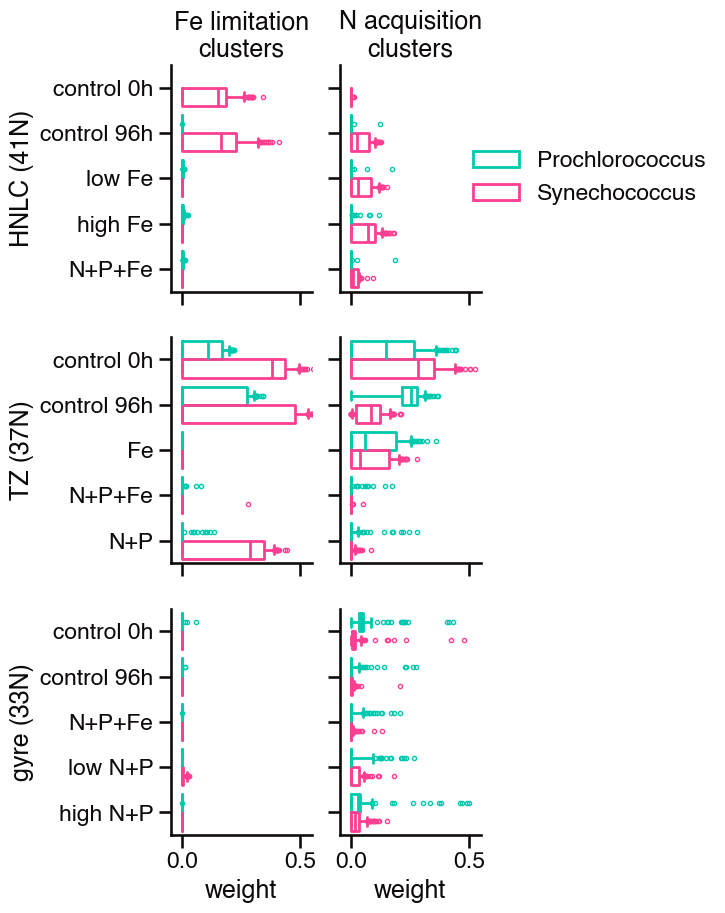

In [64]:
# incubation weights with both Fe and nitrogen clusters

# set up data
treatments = ['control 0h', 'control 96h', 'low Fe', 'high Fe', 'Fe', 'N+P+Fe', 'N+P', 'low N+P', 'high N+P']
with pd.option_context('mode.chained_assignment', None):
    fe_incubation_df = fe_cluster_df[fe_cluster_df.treatment.isin(treatments)]
    fe_incubation_df['clustergroup'] = 'Fe limitation'
    n_incubation_df = n_cluster_df[n_cluster_df.treatment.isin(treatments)]
    n_incubation_df['clustergroup'] = 'N acquisition'
incubation_df = pd.concat([fe_incubation_df, n_incubation_df]).reset_index(drop=True).fillna(0)
incubation_df = incubation_df.sort_values('treatment', key=lambda s: s.apply(treatments.index))

# set up figure
sample_weight_range = (-0.05, 0.55) # range of weights to show on sample plots
fig = plt.figure(figsize=(4, 10))
rows = 3
cols = 2
grid = plt.GridSpec(rows, cols, wspace=.2, hspace=.2)

for i, condition in enumerate(['HNLC', 'TZ', 'gyre']):
    for j, clustergroup in enumerate(['Fe limitation', 'N acquisition']):
        axis = plt.subplot(grid[i, j])
        plot_df = incubation_df[(incubation_df['condition'] == condition) & (incubation_df['clustergroup'] == clustergroup)]
        sns.boxplot(
            data=plot_df, x='sampleweights', y='treatment', hue='genus', 
            hue_order=['Prochlorococcus', 'Synechococcus'], palette=[sns.color_palette()[i] for i in [2, 3]], 
            orient='y', fill=False, whis=(5, 95), fliersize=3, legend=((i==0)&(j==1)), ax=axis
        )
        # labels and such
        if i == 0:
            axis.set(title='{}\nclusters'.format(clustergroup))
            if j == 1:
                axis.legend(loc='center left', bbox_to_anchor=(0.8, 0.5))
        if i == rows-1:
            xlabel = 'weight'
        else:
            xlabel = None
        if j == 0:
            ylabel = f"{condition} ({plot_df.latitude.mean():.0f}N)"
        else:
            ylabel = None
        axis.set(xlim=sample_weight_range, xlabel=xlabel, ylabel=ylabel)
        axis.tick_params(left=True, labelleft=(j==0), bottom=True, labelbottom=(i==rows-1))

# save figure
fig.savefig('fe-n-clusters-incubations.png', bbox_inches='tight')


# junkyard
old code not needed for the current figure

In [ ]:
# # match sample data with dissolved Fe and dissolved N data

# # only select surface and depth samples for joining
# source_df = sample_df[sample_df.samplegroup.isin(
#     ['depth profiles', 'surface transect'])].reset_index(drop=True).rename(
#     columns={'datetime': 'time', 'latitude': 'lat', 'longitude': 'lon'})
# source_cols = source_df.columns.to_list()

# # define target datasets
# targets = {
#     # dissolved Fe
#     'tblKOK1606_Gradients1_Diss_Trace_Metal_Profile': {
#         'variables': ['Fe_dissolved'], 
#         'tolerances': [1, 0.25, 0.25, 15]
#     },
#     'tblMGL1704_Gradients2_Diss_Trace_Metal_Profile': {
#         'variables': ['Fe_dissolved'], 
#         'tolerances': [1, 0.25, 0.25, 15]
#     },
#     'tblMGL1704_Gradients2_Diss_Trace_Metal_Surface': {
#         'variables': ['Fe_dissolved'], 
#         'tolerances': [1, 0.25, 0.25, 15]
#     },
#     'tblKM1906_Gradients3_Diss_Trace_Metal_Profile': {
#         'variables': ['Fe_dissolved'], 
#         'tolerances': [1, 0.25, 0.25, 15]
#     }, 
#     # dissolved N
#     'tblKOK1606_Gradients1_Nutrients': {
#         'variables': ['NO3_NO2'], 
#         'tolerances': [1, 0.25, 0.25, 15]
#     },
#     'tblMGL1704_Gradients2_Nutrients': {
#         'variables': ['NO3_NO2'], 
#         'tolerances': [1, 0.25, 0.25, 15]
#     },
#     'tblKM1906_Gradients3_Organic_Inorganic_Nutrients': {
#         'variables': ['NO3_plus_NO2'], 
#         'tolerances': [1, 0.25, 0.25, 15]
#     }
# }

# # join target data on the source dataframe
# merged_df = pycmap.Sample(
#     source=source_df, 
#     targets=targets, 
#     replaceWithMonthlyClimatolog=False
# )

# # merge all of the iron data into one column
# fe_start = 'CMAP_Fe_dissolved_tblKOK1606_Gradients1_Diss_Trace_Metal_Profile'
# fe_end = 'CMAP_Fe_dissolved_tblKM1906_Gradients3_Diss_Trace_Metal_Profile'
# merged_df['Fe_dissolved'] = merged_df.loc[:, fe_start:fe_end].max(axis=1)

# # merge all of the n data into one column
# n_start = 'CMAP_NO3_NO2_tblKOK1606_Gradients1_Nutrients'
# n_end = 'CMAP_NO3_plus_NO2_tblKM1906_Gradients3_Organic_Inorganic_Nutrients'
# merged_df['NO3_NO2'] = merged_df.loc[:, n_start:n_end].max(axis=1)

# # trim the dataframe
# merged_df = merged_df[source_cols + ['Fe_dissolved', 'NO3_NO2']]

# merged_df